# Modelling Plasma Concentration of Indomethacin 

For this project, we'll carry out exploratory analysis on Indometh dataset(built-in dataset in R) and model the plasma concentration of Indomethacin.

The dataset is about the pharmacokinetics of Indomethacin.Each of the six subjects in the experiment were given an intravenous injection of indomethacin and their plasma concentrations of indomethacin was monitored.

The dataset contains 3 variables:
1. Subject : Factor variable with subject codes
2. time : a numeric vector of times at which blood samples were drawn (hr)
3. conc : a numeric vector of plasma concentrations of indometacin (mcg/ml)

Installed packages:

In [1]:
#install.packages("lmtest")
#install.packages("statmod")
#install.packages("lme4")

Let's start by checking the data types of the 3 variables.

In [2]:
lapply(Indometh, class)

$Subject
[1] "ordered" "factor" 

$time
[1] "numeric"

$conc
[1] "numeric"

Checking the head of the dataframe:

In [3]:
head(Indometh)

Subject,time,conc
1,0.25,1.50
1,0.50,0.94
1,0.75,0.78
1,1.00,0.48
1,1.25,0.37
1,2.00,0.19


## Exploratory Analysis

Let's check how the plasma concentration of indomethacin is distributed by plotting a histogram.

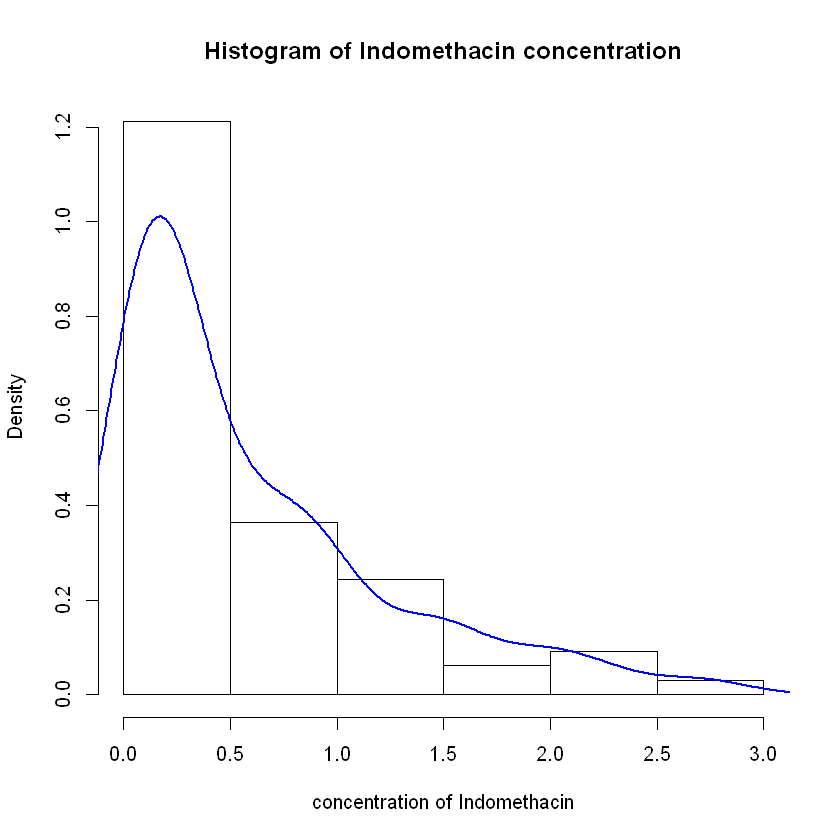

In [4]:
attach(Indometh)
hist(conc,prob = TRUE,xlab = "concentration of Indomethacin",main = "Histogram of Indomethacin concentration")
lines(density(conc), col="blue", lwd=2)

The above histogram suggests that the concentration of indomethacin is exponentially distributed.
Let's validate this observation using a Quantile-quantile plot with theoretical quantiles of exponential distribution.

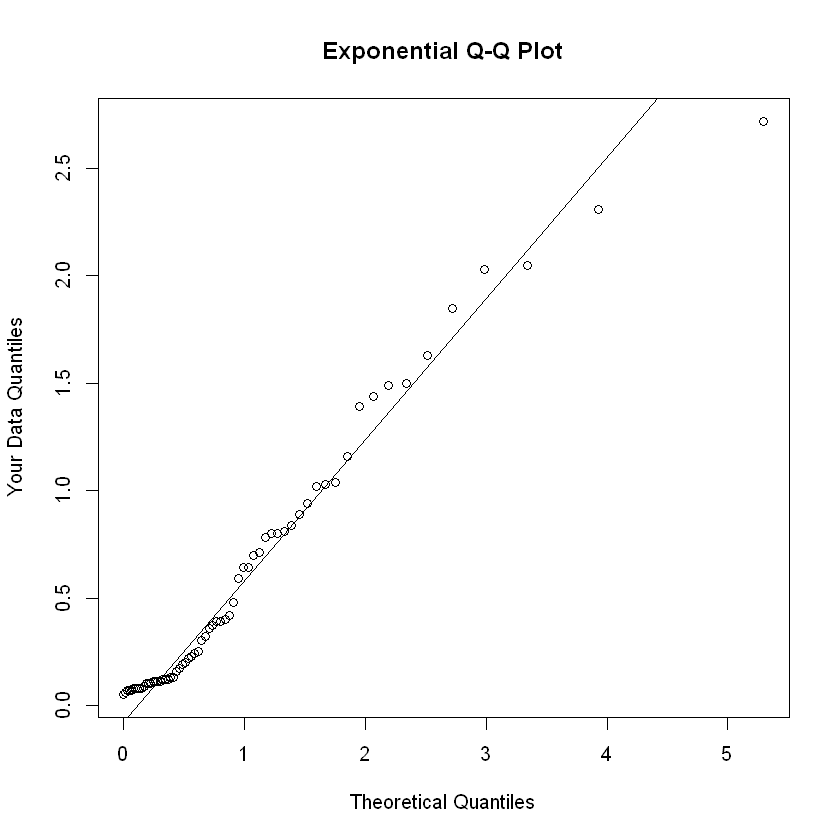

In [5]:
qqplot(x=qexp(ppoints(100)), y=conc, main="Exponential Q-Q Plot",
       xlab="Theoretical Quantiles", ylab= "Your Data Quantiles")
qqline(conc, distribution=qexp)

Though the right tail of the distribution of concentrations is deviating a bit from exponential distribution, the overall pattern of the Q-Q plot is approximately linear indicating that the concentration of indomethacin is exponentially distributed. This can be supported by Kolmogorov-Smirnov goodness of fit test(ks test).

Firstly, an exponential distribution is to be fitted to the concentration of Indomethacin by Maximum-Likelihood method and the parameters are estimated(MLE). The KS test is performed between concentration of Indomethacin and the data simulated from exponential distribution with estimated parameters(MLE).

In [6]:
library(MASS)
fit = fitdistr(conc,"exponential")
ks.test(conc,rexp(1000,fit$estimate))

Warning message in ks.test(conc, rexp(1000, fit$estimate)):
"p-value will be approximate in the presence of ties"


	Two-sample Kolmogorov-Smirnov test

data:  conc and rexp(1000, fit$estimate)
D = 0.15348, p-value = 0.1082
alternative hypothesis: two-sided


The Null hypothesis of the KS test is that both the samples are drawn from the same distribution. The p-value > 0.05 implies that the null hypothesis shouldn't be rejected and concludes the exponential distribution of concentration of Indomethacin.

Now let's examine how the concentration of Indomethacin is varying with time.

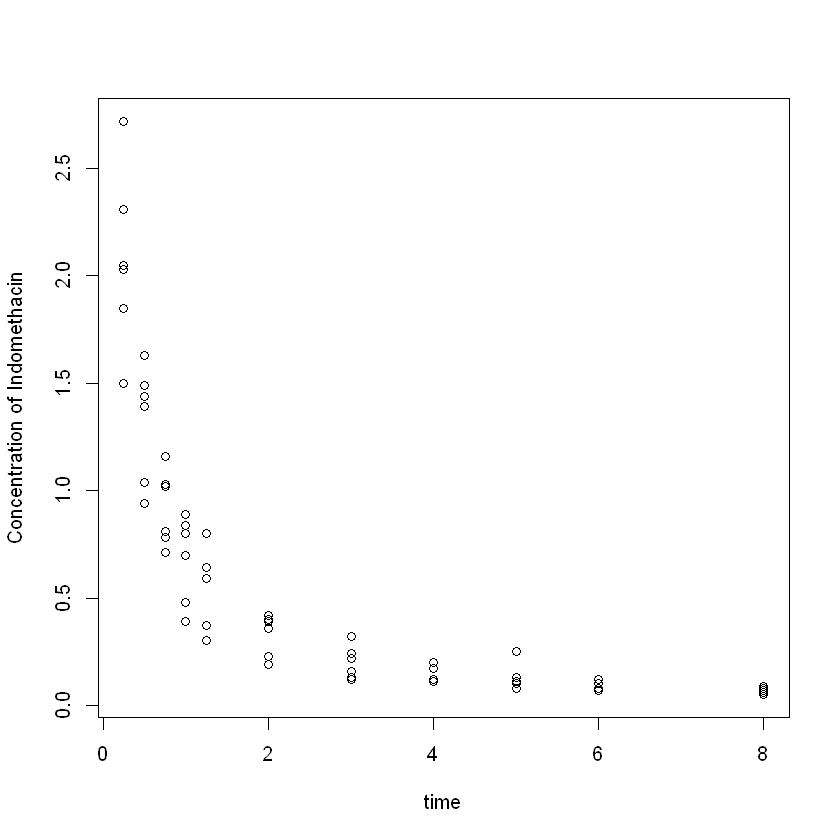

In [7]:
plot(time,conc,ylab = "Concentration of Indomethacin")

It can be inferred from the above scatterplot that the concentration of Indomethacin is inversely related to time. It can be validated by computing the correlation between concentration and inverse of time.

In [8]:
print(paste("correlation coefficient between concentration and time is", cor(conc,time)))
print(paste("correlation coefficient between concentration and inverse of time is", cor(conc,1/time)))

[1] "correlation coefficient between concentration and time is -0.710471852525009"
[1] "correlation coefficient between concentration and inverse of time is 0.951713361606039"


This concludes the inverse relation between concentration of Indomethacin and time.

## Model Fitting, Diagnostics and Evaluation

### Model Fitting

From the exploratory data analysis, we have observed:
1. Concentration of Indomethacin is exponentially distributed.
2. Concentration of Indomethacin and time are inversely related.

So, it would be ideal to fit:
1. A Gamma generalized linear model with inverse link function with Subject and time as independent variables(Model1)
2. A Gamma generalized linear model with identity link function with Subject and inverse of time as independent variables(Model2)

Let's consider linear regression model(model3) to compare the performance with model1 and model2.

Fitting the 3 models mentioned above:

In [9]:
model1 = glm(conc ~ time + Subject, family = Gamma())
time_inverse = 1/time
model2 = glm(conc ~ time_inverse + Subject, family = Gamma(link = "identity"))
model3 = glm(conc ~ time_inverse + Subject, family = gaussian())

### Model Diagnostics

Though we have fit the ideal models based on the exploratory analysis, the data themselves may indicate that a particular model is unsuitable. Thus, model diagnostics is an important precautionary step.

Diagnostics of the 3 models:
1. Informal check using deviance residuals: Standardized deviance residuals are plotted against the fitted values transformed to the constant-information scale of the error distribution.(2log($\hat{\mu}$) for gamma glm and $\hat{\mu}$ for normal glm(since the transformation is identity))

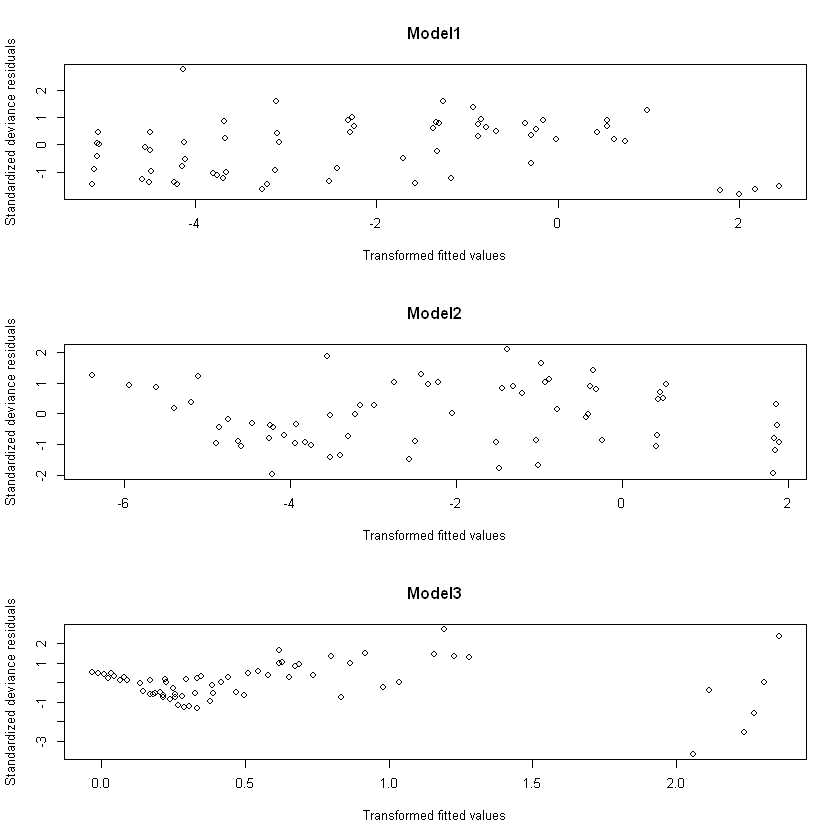

In [10]:
par(mfrow = c(3,1))
plot(2*log(fitted(model1)),rstandard(model1,type = "deviance"),xlab = "Transformed fitted values",ylab = "Standardized deviance residuals",main = "Model1")
plot(2*log(fitted(model2)),rstandard(model2,type = "deviance"),xlab = "Transformed fitted values",ylab = "Standardized deviance residuals",main = "Model2")
plot(fitted(model3),rstandard(model3,type = "deviance"),xlab = "Transformed fitted values",ylab = "Standardized deviance residuals",main = "Model3")

The null pattern of this plot is a uniform distrubtion of residuals about y = 0 line with constant range. Model1 and model2 have a null pattern, whereas model3 has change of range in residuals with fitted values.

2. Checking the link function: A plot of the adjusted dependent variable $z_{i}=\hat{\eta}_{i}+(y_{i}-\hat{\mu}_{i})(\frac{\partial\eta_{i}}{\partial\mu_{i}})_{\beta=\hat{\beta}}$ against $\hat{\eta}_{i}$ gives an informal check on the link function.

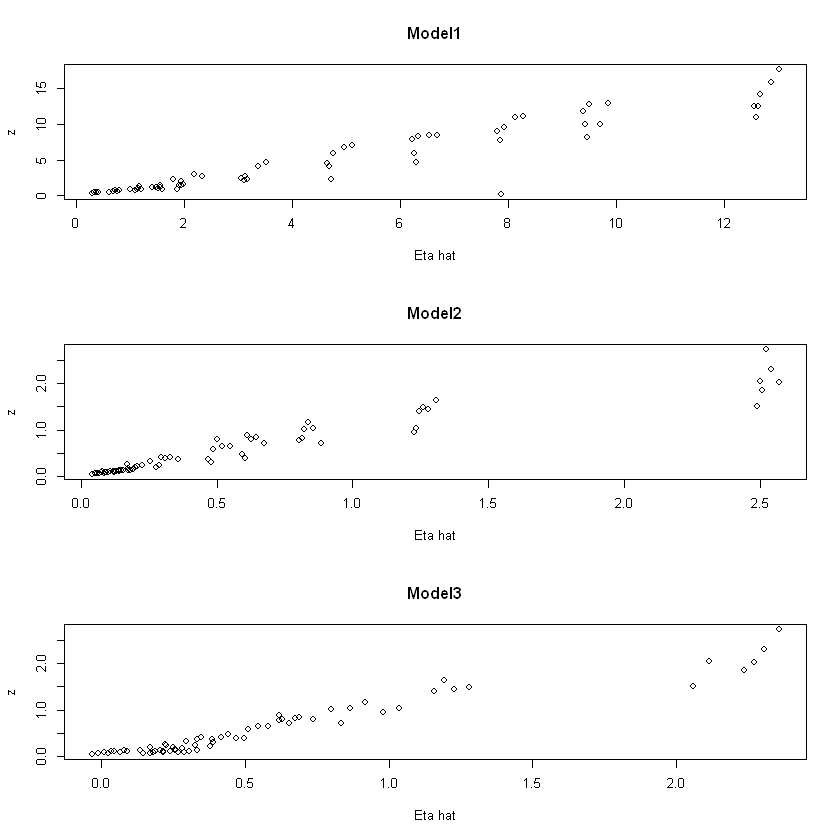

In [11]:
par(mfrow = c(3,1))
plot(1/fitted(model1),1/fitted(model1) - (conc-fitted(model1))/(fitted(model1))^2,xlab = "Eta hat",ylab = "z",main = "Model1")
plot(fitted(model2),conc,xlab = "Eta hat",ylab = "z",main = "Model2")
plot(fitted(model3),conc,xlab = "Eta hat",ylab = "z",main = "Model3")

The null pattern of this plot is a straight line. All the 3 models do not have curvature and therefore have a null pattern indicating there are no concerns with link function.

3. Checking the model fit: The actual values of dependent variable are plotted against independent variable and smooth line of the fitted model is plotted on top of this scatter plot.

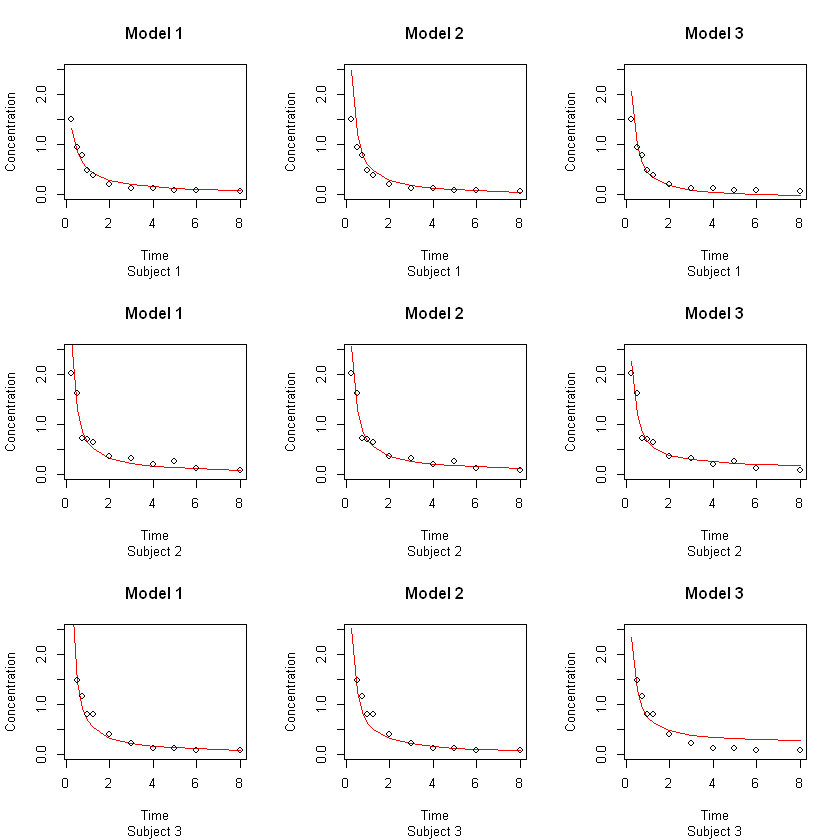

In [12]:
par(mfrow = c(3,3))
plot(time[Subject == 1],fitted(model1)[Subject == 1],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 1",main = "Model 1")
points(time[Subject == 1],conc[Subject == 1])
plot(time[Subject == 1],fitted(model2)[Subject == 1],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 1",main = "Model 2")
points(time[Subject == 1],conc[Subject == 1])
plot(time[Subject == 1],fitted(model3)[Subject == 1],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 1",main = "Model 3")
points(time[Subject == 1],conc[Subject == 1])
plot(time[Subject == 2],fitted(model1)[Subject == 2],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 2",main = "Model 1")
points(time[Subject == 2],conc[Subject == 2])
plot(time[Subject == 2],fitted(model2)[Subject == 2],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 2",main = "Model 2")
points(time[Subject == 2],conc[Subject == 2])
plot(time[Subject == 2],fitted(model3)[Subject == 2],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 2",main = "Model 3")
points(time[Subject == 2],conc[Subject == 2])
plot(time[Subject == 3],fitted(model1)[Subject == 3],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 3",main = "Model 1")
points(time[Subject == 3],conc[Subject == 3])
plot(time[Subject == 3],fitted(model2)[Subject == 3],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 3",main = "Model 2")
points(time[Subject == 3],conc[Subject == 3])
plot(time[Subject == 3],fitted(model3)[Subject == 3],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 3",main = "Model 3")
points(time[Subject == 3],conc[Subject == 3])


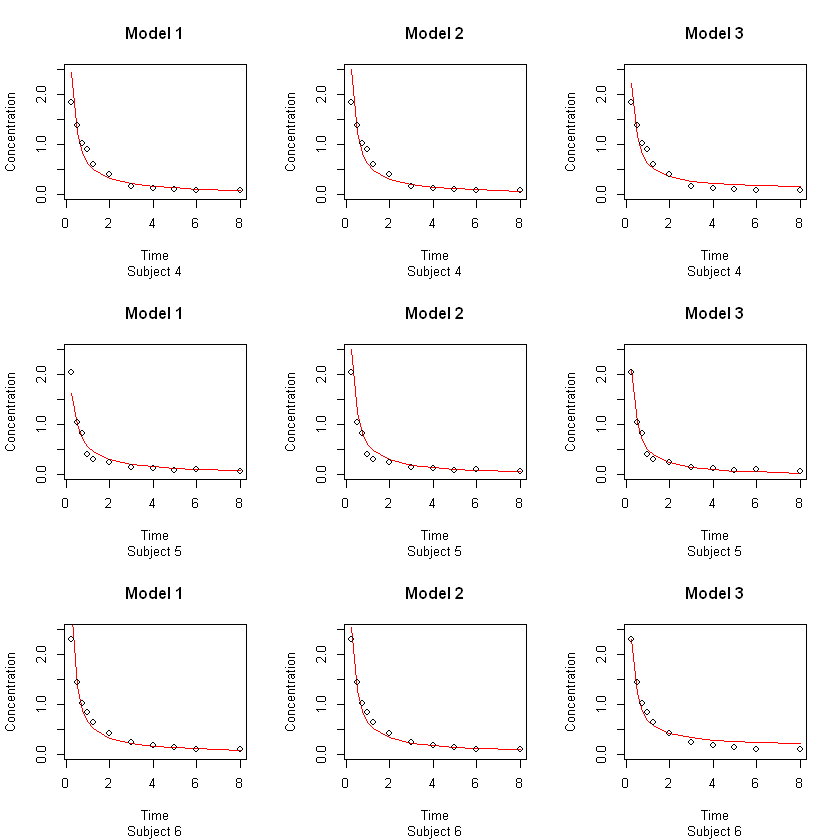

In [13]:
par(mfrow = c(3,3))
plot(time[Subject == 4],fitted(model1)[Subject == 4],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 4",main = "Model 1")
points(time[Subject == 4],conc[Subject == 4])
plot(time[Subject == 4],fitted(model2)[Subject == 4],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 4",main = "Model 2")
points(time[Subject == 4],conc[Subject == 4])
plot(time[Subject == 4],fitted(model3)[Subject == 4],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 4",main = "Model 3")
points(time[Subject == 4],conc[Subject == 4])
plot(time[Subject == 5],fitted(model1)[Subject == 5],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 5",main = "Model 1")
points(time[Subject == 5],conc[Subject == 5])
plot(time[Subject == 5],fitted(model2)[Subject == 5],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 5",main = "Model 2")
points(time[Subject == 5],conc[Subject == 5])
plot(time[Subject == 5],fitted(model3)[Subject == 5],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 5",main = "Model 3")
points(time[Subject == 5],conc[Subject == 5])
plot(time[Subject == 6],fitted(model1)[Subject == 6],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 6",main = "Model 1")
points(time[Subject == 6],conc[Subject == 6])
plot(time[Subject == 6],fitted(model2)[Subject == 6],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 6",main = "Model 2")
points(time[Subject == 6],conc[Subject == 6])
plot(time[Subject == 6],fitted(model3)[Subject == 6],ylim = c(0,2.5),type = "l",col = "red",xlab = "Time",ylab = "Concentration",sub = "Subject 6",main = "Model 3")
points(time[Subject == 6],conc[Subject == 6])

Model3 has performed well in fitting the values of concentration of Indomethacin in the early hours, however, it was inaccurate after longer periods of time. Both model1 and model2 seems to have performed equally well and raise no concerns.

Therefore, the model diagnostics conclude that there aren't any red flags raised for model1 and model2 unlike model3.

### Model Evaluation

The parameters in the generalized linear model are estimated using Maximum-Likelihood method. Unlike Gaussian glm, the Maximum-Likelihood estimates in generalized linear models aren't same as the OLS estimates. So, it's important to choose Maximum-Likelihood based evaluation metrics.

1. Akaike Information Criterion(AIC): It is an evaluation metric used to compare different possible models and determine which one is the best fit. According to AIC, the best fit model will be the one that neither under-fits nor over-fits. The best fitted model among a set of models is the one with least AIC.$$AIC=2k-2ln(\hat{L})$$where k = number of estimated parameters in the model and $\hat{L}$= maximum value of the likelihood function of the model.

2. Cox-Snell Pseudo-$R^{2}$: It is based on the log-likelihood of the model compared to the log-likelihood of a baseline model. According to pseudo-$R^{2}$, the best fit model will be the one that best predicts the observed values. The model with largest pseudo-$R^{2}$ is best fitted model according to this metric. However, this metric alone can be quite misleading as it doesn't account for the over-fitting.$$Cox-Snell R^{2}=1-(\frac{L_{0}}{L_{M}})^{\frac{2}{n}}$$where $L_{M}$= maximum value of the likelihood function of the model M and $L_{0}$= the value of likelihood function for a model with no predictors.

In [14]:
library(lmtest)
Model = c("Model1","Model2","Model3")
AIC = c(AIC(model1),AIC(model2),AIC(model3))
CoxSnell_PseudoR2 = c(1-(exp(lrtest(model1)$LogLik[2])/exp(lrtest(model1)$LogLik[1]))^(2/nrow(Indometh)),
                      1-(exp(lrtest(model2)$LogLik[2])/exp(lrtest(model2)$LogLik[1]))^(2/nrow(Indometh)),
                      1-(exp(lrtest(model3)$LogLik[2])/exp(lrtest(model3)$LogLik[1]))^(2/nrow(Indometh)))
Modelevaluation = cbind(Model,AIC,CoxSnell_PseudoR2)
Modelevaluation

Warning message:
"package 'lmtest' was built under R version 3.6.3"Loading required package: zoo
Warning message:
"package 'zoo' was built under R version 3.6.3"
Attaching package: 'zoo'

The following objects are masked from 'package:base':

    as.Date, as.Date.numeric



Model,AIC,CoxSnell_PseudoR2
Model1,-120.268806155195,0.951614426090176
Model2,-136.270458748901,0.962031668607647
Model3,-37.3350665495358,0.933783979350241


Both model1 and model2 are significantly better than model3 as expected. Moreover, model2 has slightly outperformed model1.

## Fitting Generalized Linear Mixed Model

“When a sample exhausts the population, the corresponding variable is fixed; when the sample is a small (i.e., negligible) part of the population the corresponding variable is random.” (Green and Tukey, 1960).

Only 6 subjects have participated in the trial which is a very small part of the study population. Thus, considering the variable Subject as fixed, limits the analysis to sample and cannot be generalized to the entire study population. So, the variable subject is to taken as a random effect which accounts for the whole study population.

Since the model2 has been the most accurate and best fit among the 3 models, we now fit a model completely similar to model2 except for the variable Subject, which is to be taken as a random effect.

In [15]:
library(lme4)
glmm_model = glmer(conc ~ time_inverse + (1|Subject),family = Gamma(link = "identity"))
summary(glmm_model)

Warning message:
"package 'lme4' was built under R version 3.6.3"Loading required package: Matrix


Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: Gamma  ( identity )
Formula: conc ~ time_inverse + (1 | Subject)

     AIC      BIC   logLik deviance df.resid 
  -131.3   -122.5     69.6   -139.3       62 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-1.58975 -0.81742 -0.09783  0.75494  2.68918 

Random effects:
 Groups   Name        Variance Std.Dev.
 Subject  (Intercept) 0.000319 0.01786 
 Residual             0.063906 0.25280 
Number of obs: 66, groups:  Subject, 6

Fixed effects:
              Estimate Std. Error t value Pr(>|z|)    
(Intercept)  -0.002116   0.015849  -0.134    0.894    
time_inverse  0.635091   0.028015  22.670   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Correlation of Fixed Effects:
            (Intr)
time_invers -0.377

Therefore, the Population model is:$$E(conc|time,Subject)=-0.0021+0.6351(\frac{1}{time})+N(0,0.0179)$$

It can be concluded that the model is a really good fit for that data with an AIC of -131.3 and is ready for the real world setting as it gives a strong realtion between concentration and time, and also it addresses the entire population by treating Subject as random variable.